In [8]:
import pandas as pd
import json

### Link to the dataset

https://www.kaggle.com/datasets/wordsforthewise/lending-club/data?select=accepted_2007_to_2018Q4.csv.gz

In [9]:
#rejected_loan_data = pd.read_csv('data/rejected_2007_to_2018Q4.csv.gz')
# loan_data = pd.read_csv('data/accepted_2007_to_2018Q4.csv.gz')
loan_data = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


C:\Users\danie\AppData\Local\Temp\ipykernel_34064\1200577519.py:3: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


In [10]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


`issue_d` Month and year when the loan was issued

`addr_state` State provided by the borrower in the loan application

`loan_status` Current status of the loan

In [11]:
loan_data['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [12]:
# # Check null values
# loan_data[loan_data['loan_status'].isnull()]

In [13]:
# loan_data[loan_data['loan_status'].isnull()].index == loan_data[loan_data['issue_d'].isnull()].index

In [14]:
loan_data['issue_d'].head()

0    Dec-2015
1    Dec-2015
2    Dec-2015
3    Dec-2015
4    Dec-2015
Name: issue_d, dtype: object

In [15]:
# Drop unnecessary id columns
loan_data = loan_data.drop(columns=['id', 'member_id'])

# Drop null values in issue_d (and target) column
loan_data = loan_data[loan_data['issue_d'].notnull()]

In [16]:
# Add year column from issue date
loan_data['issue_year'] = loan_data['issue_d'].str[-4:].astype(int)
#loan_data['issue_year'] = loan_data['issue_d'].astype('datetime64[ns]').dt.year

In [17]:
loan_data[['issue_d', 'issue_year']].sample(10)

,issue_d,issue_year
1746347,Jan-2017,2017
2037635,Jul-2016,2016
110774,Oct-2015,2015
202167,Jul-2015,2015
1345095,Jan-2014,2014
376279,Feb-2015,2015
1209660,Aug-2014,2014
415468,Jan-2015,2015
859551,Jul-2018,2018
97089,Nov-2015,2015


### Import yearly unemployment rate data

### Link to the datasets

https://fred.stlouisfed.org/release/tables?rid=116&eid=840687

In [18]:
# Load unemployment rate data from multiple csv files and merge them on observation_date
paths = ["data/unemployment_rate_0.csv", "data/unemployment_rate_1.csv", "data/unemployment_rate_2.csv", "data/unemployment_rate_3.csv", "data/unemployment_rate_4.csv"]

y_unemployment_df = pd.read_csv(paths[0])
for path in paths[1:]:
    df = pd.read_csv(path)
    y_unemployment_df = y_unemployment_df.merge(df, on="observation_date", how="outer")

In [19]:
# Add year column from observation date
y_unemployment_df['year'] = y_unemployment_df['observation_date'].astype('datetime64[ns]').dt.year

# Drop observation date column
y_unemployment_df = y_unemployment_df.drop(columns=['observation_date'])

# Import column names
with open('data/unemployment_rate_dict.json') as f:
    states_ref = json.load(f)

states_names = list(states_ref.keys())
col_names = states_names + ["year"]

# Rename columns
y_unemployment_df.columns = col_names

# Reshape unemployment data to long format
y_unemployment_df = y_unemployment_df.melt(id_vars=["year"], var_name="state", value_name="y_unemployment_rate")

In [20]:
y_unemployment_df.head()

,year,state,y_unemployment_rate
0,1976,AL,6.7
1,1977,AL,7.1
2,1978,AL,6.5
3,1979,AL,7.2
4,1980,AL,8.7


### Merge unemployment rates with loan data

In [21]:
data = loan_data.merge(
    y_unemployment_df,
    left_on=["issue_year", "addr_state"],
    right_on=["year", "state"],
    how="left"
).drop(columns=["year", "state"])

In [22]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_year,y_unemployment_rate
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2015,5.4
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2015,3.0
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2015,6.0
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2015,5.7
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2015,5.4


In [23]:
data.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,issue_year,y_unemployment_rate
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,2.260668e+06,...,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000,2.260668e+06,2.260668e+06
mean,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,7.025884e+02,...,3.0,13.743886,454.798089,11636.883942,193.994321,5010.664267,47.780365,13.191322,2.015858e+03,5.136046e+00
std,9.190245e+03,9.188413e+03,9.192332e+03,4.832138e+00,2.671735e+02,1.126962e+05,1.418333e+01,8.672303e-01,3.301038e+01,3.301124e+01,...,0.0,9.671178,375.385500,7625.988281,198.629496,3693.122590,7.311822,8.159980,1.792634e+00,1.456321e+00
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,6.140000e+02,...,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000,2.007000e+03,2.200000e+00
25%,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.189000e+01,0.000000e+00,6.750000e+02,6.790000e+02,...,3.0,5.000000,175.230000,5627.000000,44.440000,2208.000000,45.000000,6.000000,2.015000e+03,4.300000e+00
50%,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.784000e+01,0.000000e+00,6.900000e+02,6.940000e+02,...,3.0,15.000000,352.770000,10028.390000,133.160000,4146.110000,45.000000,14.000000,2.016000e+03,4.900000e+00
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.449000e+01,0.000000e+00,7.150000e+02,7.190000e+02,...,3.0,22.000000,620.175000,16151.890000,284.190000,6850.172500,50.000000,18.000000,2.017000e+03,5.800000e+00
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,8.500000e+02,...,3.0,37.000000,2680.890000,40306.410000,1407.860000,33601.000000,521.350000,181.000000,2.018000e+03,1.350000e+01


### Income 2024 by state

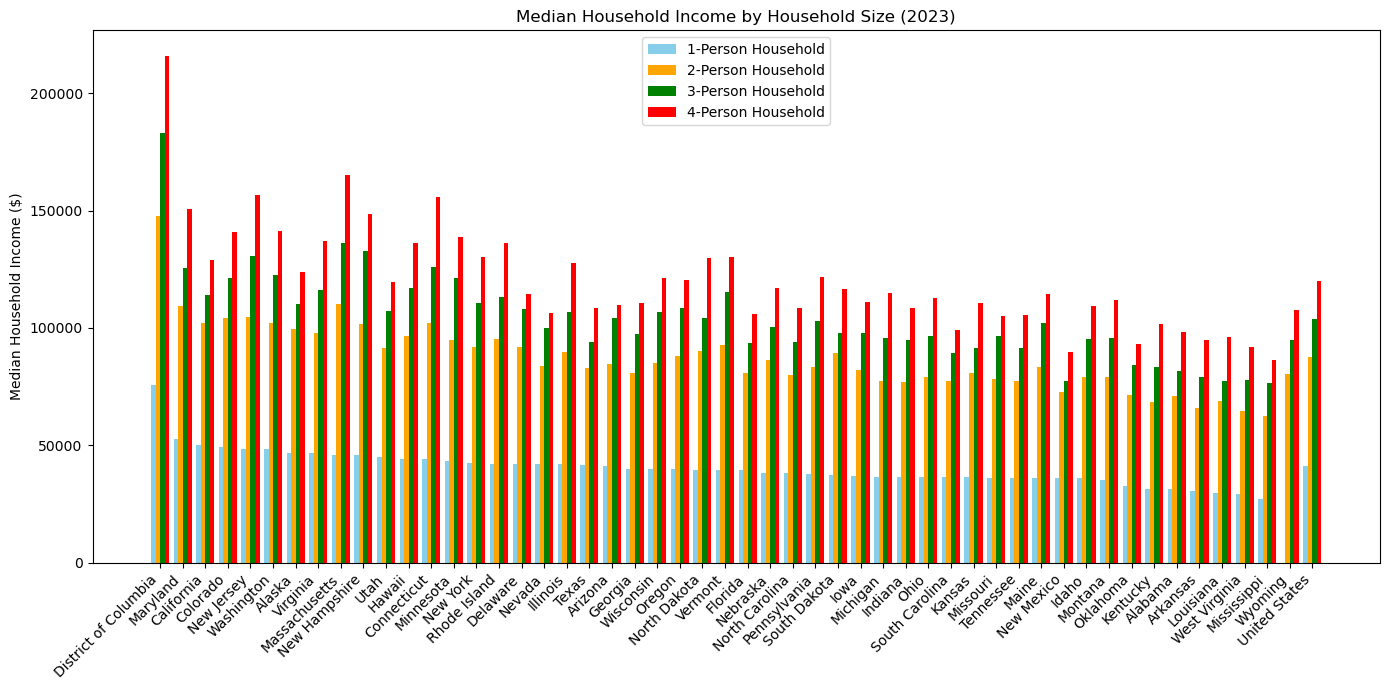

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read CSV file
df = pd.read_csv("income2024ByState/median-household-income-by-state-2025.csv")

# Extract the relevant columns
states = df["state"].tolist()
income_1 = df["MedianHouseholdIncomeInOnePersonHousehold_2023"].tolist()
income_2 = df["MedianHouseholdIncomeInTwoPersonHousehold_2023"].tolist()
income_3 = df["MedianHouseholdIncomeInThreePersonHousehold_2023"].tolist()
income_4 = df["MedianHouseholdIncomeInFourPersonHousehold_2023"].tolist()

# X locations
x = np.arange(len(states))  
width = 0.2

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(x - 1.5*width, income_1, width, label="1-Person Household", color="skyblue")
ax.bar(x - 0.5*width, income_2, width, label="2-Person Household", color="orange")
ax.bar(x + 0.5*width, income_3, width, label="3-Person Household", color="green")
ax.bar(x + 1.5*width, income_4, width, label="4-Person Household", color="red")

# Labels and formatting
ax.set_ylabel("Median Household Income ($)")
ax.set_title("Median Household Income by Household Size (2023)")
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


### Income per state 2022 and 23

Index(['State', '2022medianHouseholdIncomeInDollars', '2022marginOfError',
       '2023medianHouseholdIncomeInDollars', '2023marginOfError',
       'ChangeInMedianIncomePercentEstimate',
       'ChangeInMedianIncomePercentMarginOfError', '2022ACSGiniIndexEstimate',
       '2022ACSGiniIndexMarginOfError', '2023ACSGiniIndexEstimate',
       '2023ACSGiniIndexMarginOfError', 'changeInGiniIndexPercentEstimate',
       'changeInGiniIndexPercentMarginOfError'],
      dtype='object')


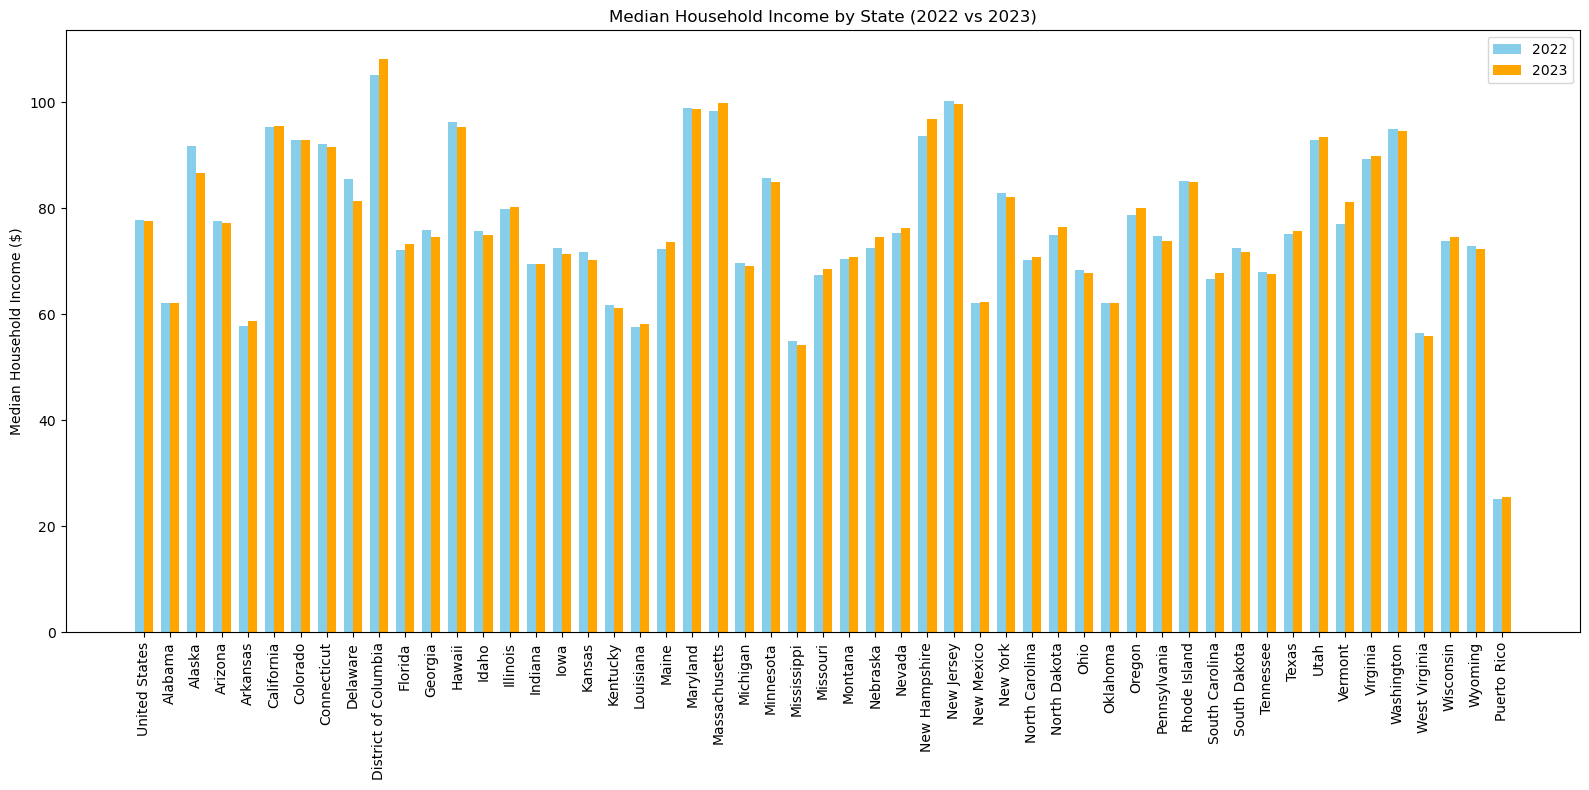

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read CSV and clean headers
df = pd.read_csv("medianHousholdIncomePast12Months2022and23.csv")
df.columns = df.columns.str.strip()  # remove whitespace
df.columns = df.columns.str.replace("*", "", regex=False)  # remove stray asterisks/dashes

print(df.columns)  # 👈 check actual column names

# Extract data
states = df["State"].tolist()
income_2022 = df["2022medianHouseholdIncomeInDollars"].tolist()
income_2023 = df["2023medianHouseholdIncomeInDollars"].tolist()

# X positions
x = np.arange(len(states))
width = 0.35  # wider bars since just 2 per group

# Plot
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x - width/2, income_2022, width, label="2022", color="skyblue")
ax.bar(x + width/2, income_2023, width, label="2023", color="orange")

# Labels and formatting
ax.set_ylabel("Median Household Income ($)")
ax.set_title("Median Household Income by State (2022 vs 2023)")
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90)  # rotate to fit all states
ax.legend()

plt.tight_layout()
plt.show()


In [18]:
dfMetadata = pd.read_csv("incomeUSPerYear/ACSST1Y2010.S1901-Column-Metadata.csv")
dfData = pd.read_csv("incomeUSPerYear/ACSST1Y2010.S1901-Data.csv")

#dfMetadata.shape
dfData.shape

(2, 131)

In [20]:
import pandas as pd
import glob
import re

all_years = []

# Loop through all Data.csv files
for filepath in glob.glob("incomeUSPerYearCopy/ACSST1Y20*.S1901-Data.csv"):
    # Extract year from filename
    year = re.search(r"ACSST1Y(\d{4})", filepath).group(1)
    
    # Load data
    df = pd.read_csv(filepath)
    
    # Add year
    df["year"] = int(year)
    
    # Melt into long format (variable per row)
    df_long = df.melt(id_vars=["GEO_ID", "NAME", "year"],
                      var_name="variable_code",
                      value_name="value")
    
    all_years.append(df_long)

# Combine all years
long_df = pd.concat(all_years, ignore_index=True)

# Load metadata (just use one, they’re identical across years)
meta = pd.read_csv("incomeUSPerYearCopy/ACSST1Y2010.S1901-Column-Metadata.csv")

# Merge labels
long_df = long_df.merge(meta, left_on="variable_code", right_on="Column Name", how="left")

# Now you have: GEO_ID | NAME | year | variable_code | value | Label
print(long_df.head())


      GEO_ID                  NAME  year   variable_code  \
0  Geography  Geographic Area Name  2010  S1901_C03_001E   
1  0100000US         United States  2010  S1901_C03_001E   
2  Geography  Geographic Area Name  2010  S1901_C03_001M   
3  0100000US         United States  2010  S1901_C03_001M   
4  Geography  Geographic Area Name  2010  S1901_C04_001E   

                                             value     Column Name  \
0         Married-couple families!!Estimate!!Total  S1901_C03_001E   
1                                         55704781  S1901_C03_001E   
2  Married-couple families!!Margin of Error!!Total  S1901_C03_001M   
3                                           151621  S1901_C03_001M   
4            Nonfamily households!!Estimate!!Total  S1901_C04_001E   

                                             Label  
0         Married-couple families!!Estimate!!Total  
1         Married-couple families!!Estimate!!Total  
2  Married-couple families!!Margin of Error!!Total  
3  Mar

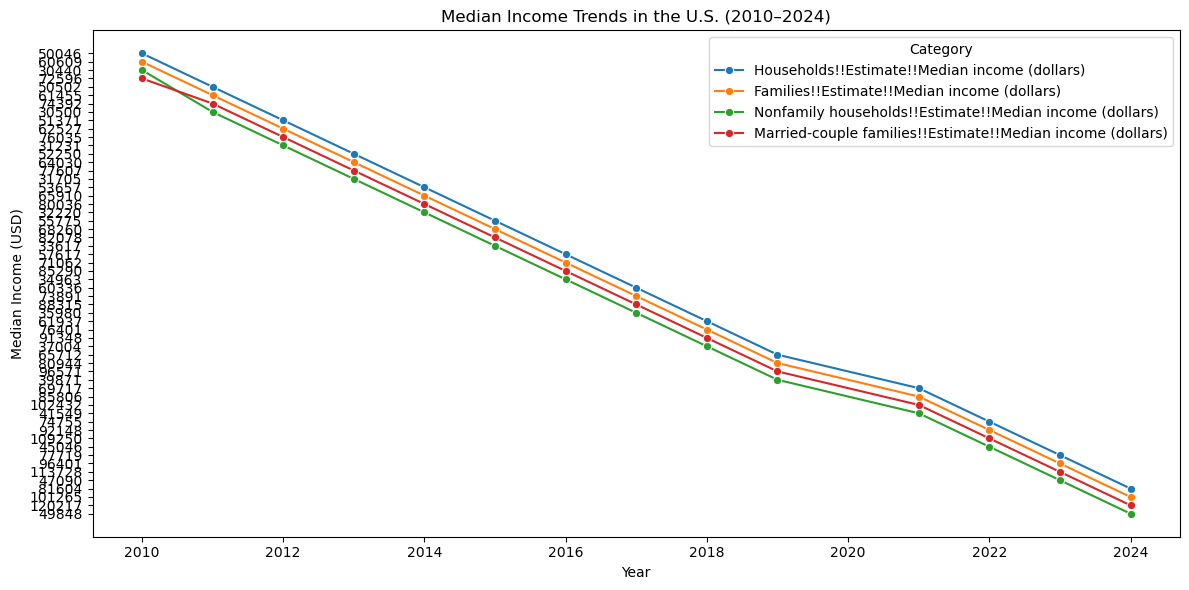

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for median income categories
median_cats = [
    "Households!!Estimate!!Median income (dollars)",
    "Families!!Estimate!!Median income (dollars)",
    "Nonfamily households!!Estimate!!Median income (dollars)",
    "Married-couple families!!Estimate!!Median income (dollars)"
]

# Subset data
df_median = long_df[long_df["Label"].isin(median_cats)]

# Example: focus on United States
df_us = df_median[df_median["NAME"] == "United States"]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_us, x="year", y="value", hue="Label", marker="o")
plt.title("Median Income Trends in the U.S. (2010–2024)")
plt.ylabel("Median Income (USD)")
plt.xlabel("Year")
plt.legend(title="Category")
plt.tight_layout()
plt.show()


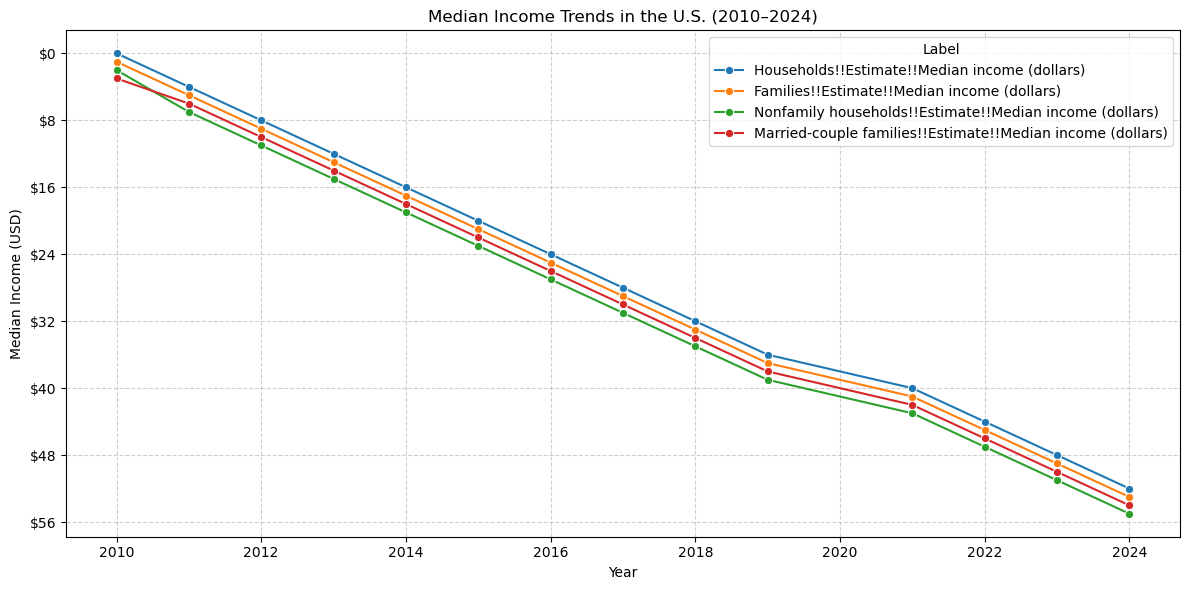

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Filter for median income categories
median_cats = [
    "Households!!Estimate!!Median income (dollars)",
    "Families!!Estimate!!Median income (dollars)",
    "Nonfamily households!!Estimate!!Median income (dollars)",
    "Married-couple families!!Estimate!!Median income (dollars)"
]

# Subset data
df_median = long_df[long_df["Label"].isin(median_cats)]

# Example: focus on United States
df_us = df_median[df_median["NAME"] == "United States"]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_us, x="year", y="value", hue="Label", marker="o")

plt.title("Median Income Trends in the U.S. (2010–2024)")
plt.ylabel("Median Income (USD)")
plt.xlabel("Year")

ax = plt.gca()
ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # ~10 ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


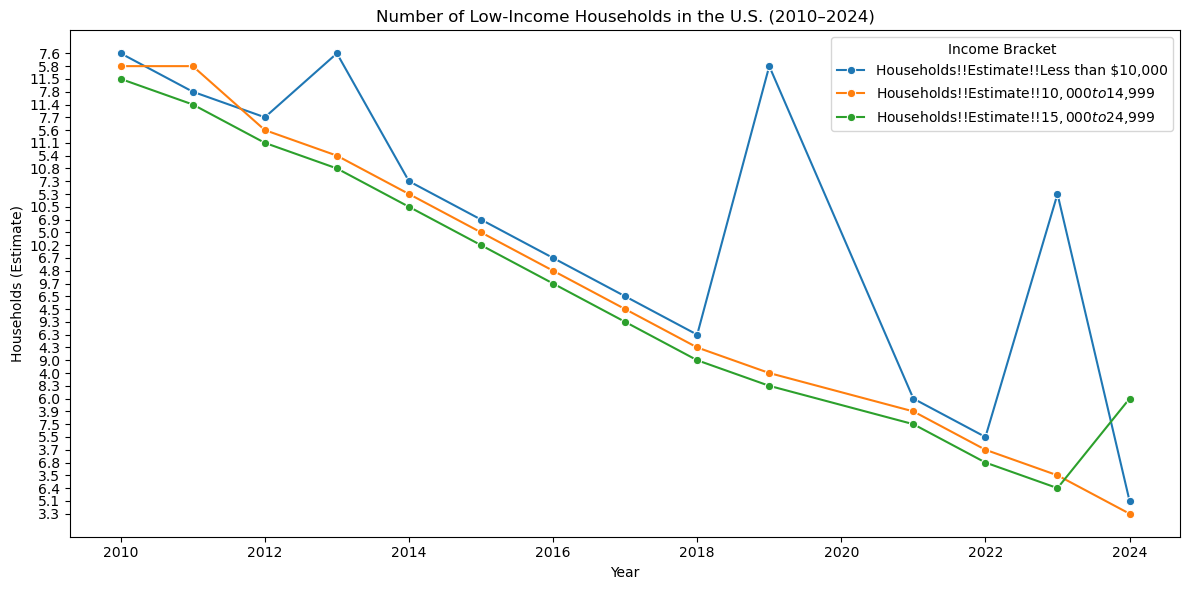

In [25]:
# Filter for households under $25k
low_income_cats = [
    "Households!!Estimate!!Less than $10,000",
    "Households!!Estimate!!$10,000 to $14,999",
    "Households!!Estimate!!$15,000 to $24,999"
]

df_low = long_df[long_df["Label"].isin(low_income_cats)]
df_us_low = df_low[df_low["NAME"] == "United States"]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_us_low, x="year", y="value", hue="Label", marker="o")
plt.title("Number of Low-Income Households in the U.S. (2010–2024)")
plt.ylabel("Households (Estimate)")
plt.xlabel("Year")
plt.legend(title="Income Bracket")
plt.tight_layout()
plt.show()


In [ ]:
ineq_cats = [
    "Households!!Estimate!!Median income (dollars)",
    "Households!!Estimate!!Mean income (dollars)"
]

df_ineq = long_df[long_df["Label"].isin(ineq_cats)]
df_us_ineq = df_ineq[df_ineq["NAME"] == "United States"]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_us_ineq, x="year", y="value", hue="Label", marker="o")
plt.title("Median vs Mean Household Income in the U.S. (2010–2024)")
plt.ylabel("Income (USD)")
plt.xlabel("Year")
plt.legend(title="Statistic")
plt.tight_layout()
plt.show()
